In [1]:
import numpy as np
from scipy import sparse 
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
import networkx as nx
import random
import pandas as pd
from datetime import date, timedelta
from collections import Counter
import time
from tqdm import tqdm
import pickle
random.seed(42)

In [2]:
with open("../data/graph/edges.M.pkl", "rb") as f:
    edge_holder = pickle.load(f)

In [3]:
edges = edge_holder["edges"]
edges, len(edges)

(array([[122306, 126785,  15006],
        [ 95108, 126785,  15006],
        [ 95108, 122306,  15006],
        ...,
        [ 30651,  65273,  19119],
        [ 30651,  90807,  19119],
        [ 30651,  35865,  19119]]),
 12730596)

In [4]:
degree_count = {}

for v1, v2, _ in edges:
    degree_count[v1] = degree_count.get(v1, 0) + 1
    degree_count[v2] = degree_count.get(v2, 0) + 1

# Analysis

3
261082


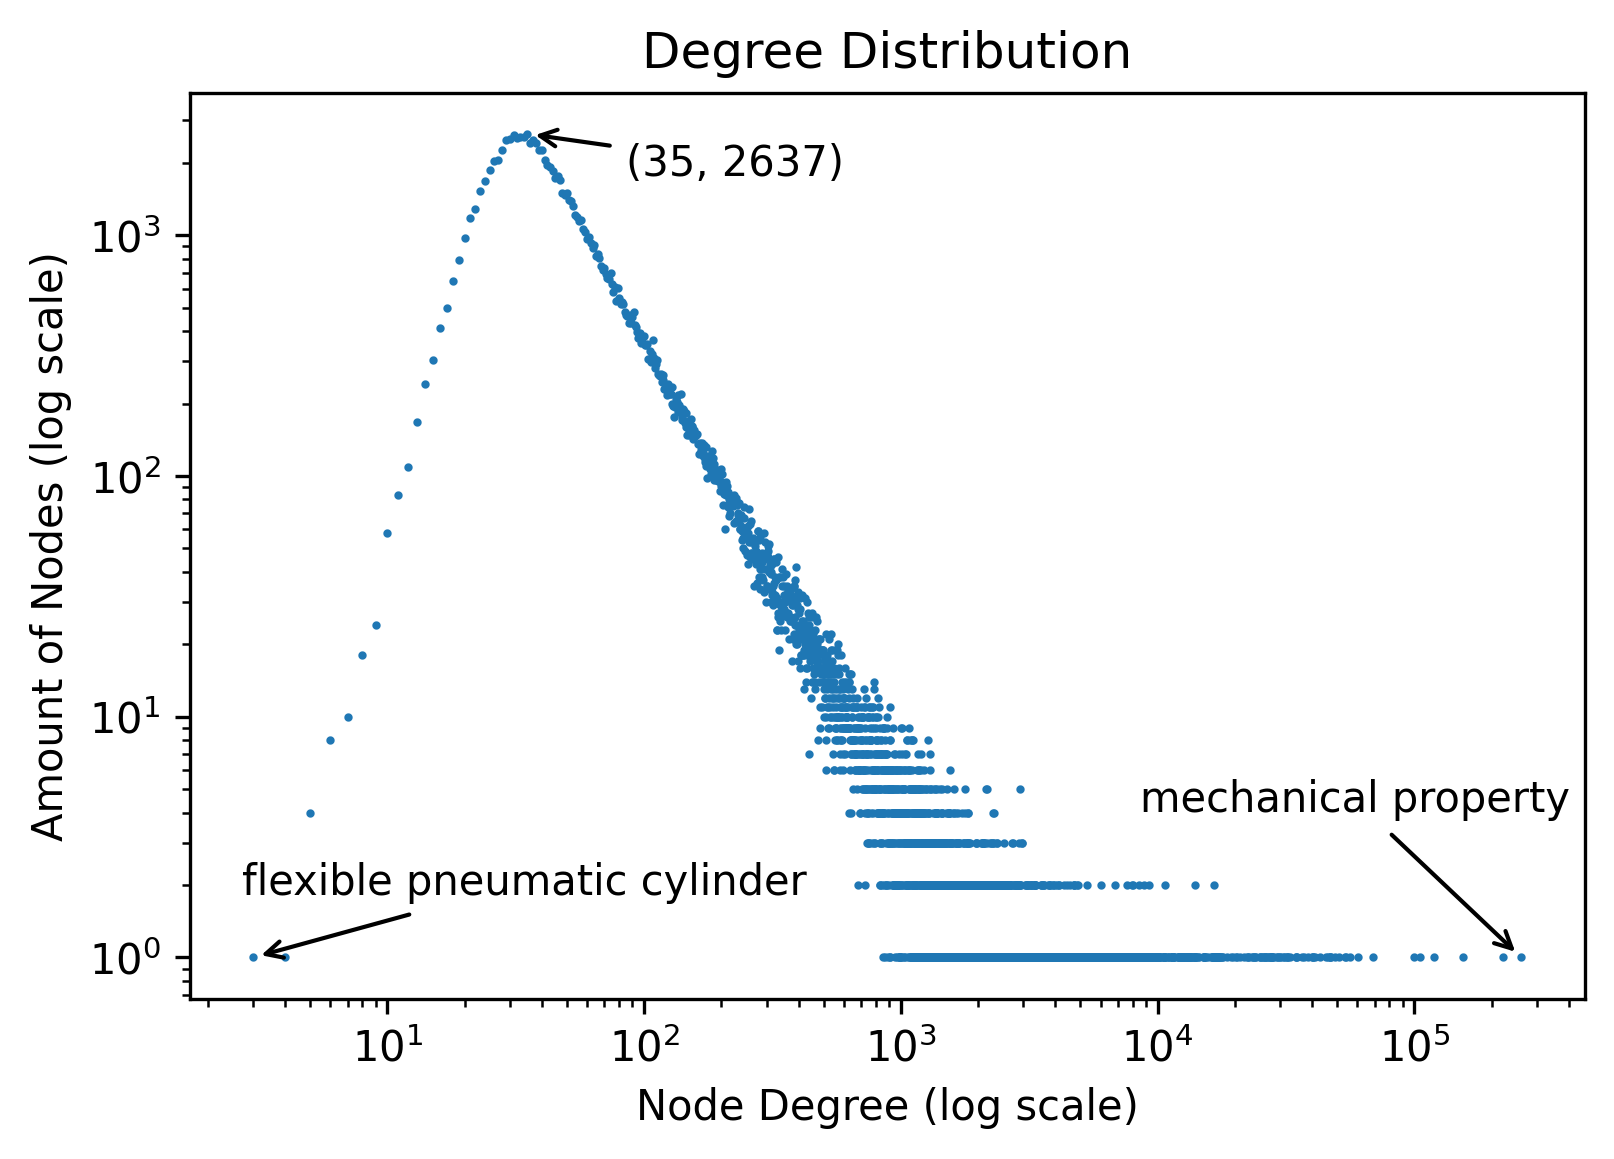

In [51]:
data = Counter(degree_count.values())

x, y = zip(*data.items())

fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
plt.xscale("log")
plt.yscale("log")

# Add annotations
max_y = max(y)
min_y = min(y)
max_x = max(x)
min_x = min(x)

print(min_x)
print(max_x)


x_max = x[y.index(max(y))]
ax.annotate(f'({x_max}, {max_y})', 
            (x_max, max_y), 
            textcoords="offset points", 
            xytext=(50,-10),
            ha='center', 
            arrowprops=dict(facecolor='black', arrowstyle='->'))

ax.annotate('flexible pneumatic cylinder', 
            (min_x, min_y), 
            textcoords="offset points", 
            xytext=(65,15),
            ha='center', 
            arrowprops=dict(facecolor='black', arrowstyle='->'))

ax.annotate('mechanical property', 
            (max_x, min_y), 
            textcoords="offset points", 
            xytext=(-40,35),
            ha='center', 
            arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('Degree Distribution')
plt.xlabel('Node Degree (log scale)')
plt.ylabel('Amount of Nodes (log scale)')
plt.show()


In [6]:
origin = date(1970, 1, 1)
years = [(origin + timedelta(days=int(days))).year for _, _, days in edges]

In [7]:
def build_adj_matrix(edge_list):
    """Build a symmetric adjacency matrix from edge list."""
    EDGE_WEIGHT = np.ones(len(edge_list) * 2)  # each connection weights the same

    row_ind = np.concatenate((edge_list[:, 0], edge_list[:, 1]))
    col_ind = np.concatenate((edge_list[:, 1], edge_list[:, 0]))

    return sparse.csr_matrix(
        (
            EDGE_WEIGHT,
            (row_ind, col_ind),
        ),
        dtype=int
    )

ADJ_MAT = build_adj_matrix(edges)

G = nx.from_scipy_sparse_array(
    ADJ_MAT,
    parallel_edges=False,
)

# Concepts

Filter: 
- Occurence >= 3
- Words >= 3

Element-specific:
- No single elements (i.e. Na)
- No duplicates (i.e. IIINV, CH3COONa, Ga2O3Gd2O3)

In [43]:
lookup = pd.read_csv("../data/table/lookup/lookup.M.2.csv")

def transform(vs):
    return [lookup.loc[index]["concept"] for index in vs]

pd.set_option('display.max_columns', None) # no ... in listing
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
most_frequent = lookup.sort_values('count', ascending=False)[["concept", "count"]].head(100)
less_frequent = lookup.sort_values('count', ascending=True)[["concept", "count"]]

# Vertices

In [44]:
sorted_pairs_mf = sorted(degree_count.items(), key=lambda x: x[1], reverse=True)
sorted_pairs_mf = [(transform([vertex])[0],count) for vertex,count in sorted_pairs_mf][:50]

sorted_pairs_lf = sorted(degree_count.items(), key=lambda x: x[1], reverse=False)
sorted_pairs_lf = [(transform([vertex])[0],count) for vertex,count in sorted_pairs_lf]


In [45]:
merged_mf = most_frequent.merge(pd.DataFrame(sorted_pairs_mf, columns=["concept", "degree"]), on=["concept"])
merged_mf

,concept,count,degree
0,mechanical property,22931,261082
1,x ray diffraction,18021,221632
2,scanning electron microscopy,12185,154809
3,transmission electron microscopy,9462,118857
4,tensile strength,8840,105074
5,electron microscopy,8001,99775
6,SiC,6402,68771
7,grain size,5273,60612
8,aluminium alloy,5075,56272
9,grain boundary,4675,53671


In [46]:
merged_lf = less_frequent.merge(pd.DataFrame(sorted_pairs_lf, columns=["concept", "degree"]), on=["concept"])
merged_lf.sort_values('degree', ascending=True).head(30)

,concept,count,degree
14827,flexible pneumatic cylinder,3,3
52969,pulsating jig,4,4
14459,expanded graphite worm,3,5
29666,precision measurement,3,5
34293,compression anastomosis,3,5
14853,flexible manufacturing system,3,5
23012,trace metal,3,6
19712,vibrating system,3,6
6421,linear measurement,3,6
29174,screw compressor,3,6


In [11]:
print(merged.to_latex(index=False))

\begin{tabular}{lrr}
\toprule
                                concept &  count &  degree \\
\midrule
                    mechanical property &  22931 &  261082 \\
                      x ray diffraction &  18021 &  221632 \\
           scanning electron microscopy &  12185 &  154809 \\
       transmission electron microscopy &   9462 &  118857 \\
                       tensile strength &   8840 &  105074 \\
                    electron microscopy &   8001 &   99775 \\
                                    SiC &   6402 &   68771 \\
                             grain size &   5273 &   60612 \\
                        aluminium alloy &   5075 &   56272 \\
                         grain boundary &   4675 &   53671 \\
                         yield strength &   4202 &   54042 \\
                    plastic deformation &   4151 &   46884 \\
                       optical property &   4125 &   50866 \\
                                   TiO2 &   4085 &   49291 \\
                               

In [12]:
DAY_ORIGIN = date(1970, 1, 1)

def get_until(graph, day):
    return graph[graph[:, 2] < (day - DAY_ORIGIN).days]

years = [date(x, 12, 31) for x in range(1970, 2024)]


ccs = []
for year in tqdm(years):
    G = nx.from_scipy_sparse_array(
        build_adj_matrix(
            get_until(edges, year)
        ),
        parallel_edges=True,
        create_using=nx.MultiGraph
    )
        
    ccs.append(
       [c for c in nx.connected_components(G) if len(c) > 1]
    )

100%|████████████████████████████████████████████████████████████████████| 54/54 [2:57:34<00:00, 197.31s/it]


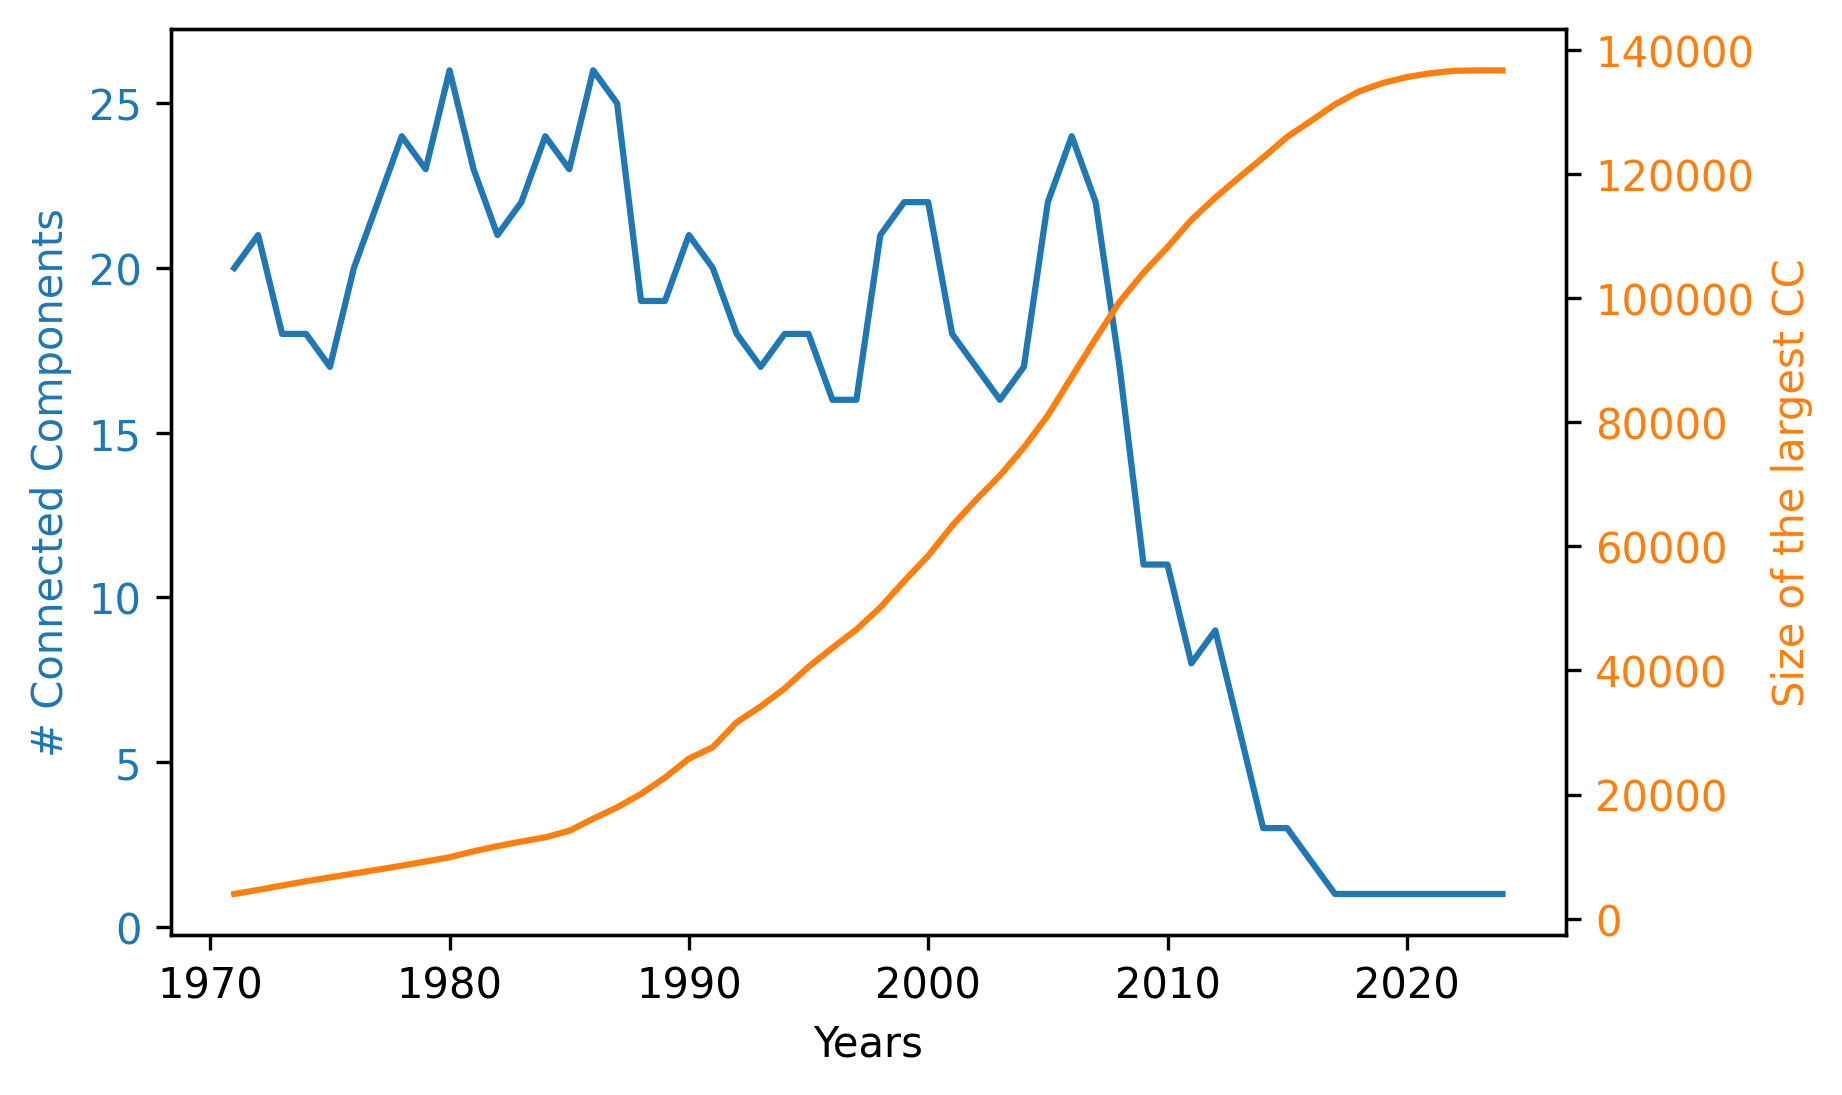

In [14]:
fig, ax1 = plt.subplots()
y1 = [len(c) for c in ccs]
y2 = [max({len(sub_c) for sub_c in c}) for c in ccs]

color = 'tab:blue'
ax1.set_xlabel('Years')
ax1.set_ylabel('# Connected Components', color=color)
ax1.plot(years, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Size of the largest CC', color=color)
ax2.plot(years, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

In [16]:
with open('css.pickle', 'wb') as handle:
    pickle.dump(ccs, handle, protocol=pickle.HIGHEST_PROTOCOL)
